In [2]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.dates import AutoDateLocator
loc10 = plticker.MultipleLocator(base=10)

# Data Quality EDA

## Questions for March 9th

1. Is the data work just a matter of filling gaps in the WB, WIOD, OECD, WHO data?
2. What are the target countries/timespans we're looking to model?
3. Are there data types that aren't covered in the current documentations? (e.g. household size)
4. What is the prioritization on empirical fitting? (i.e. What agent-traits can we assume to be normally distributed, etc., in case there's no good/accessible data?)


## World Bank Data

In [3]:
f = h5py.File('./sample_data/world_bank.h5', 'r')
print("Keys: %s" % list(f.keys()))
a_group_key = list(f.keys())[0]
a_group_key

wb_dict = {}
for i in f.keys():
    wb_dict[i] = pd.read_hdf('./sample_data/world_bank.h5', key=i)

Keys: ['birth_rates', 'cpi', 'gdp', 'govt_debt', 'historic_cpi', 'historic_gdp', 'interest_rates', 'long_term_ir', 'participation', 'short_term_ir', 'tau_exp', 'tau_vat', 'unemployment']


In [4]:
def wb_missing_time(d):

    years_str = [str(i) for i in range(1960, 2021)]
    years = list(range(1960, 2021))
    fig, axes = plt.subplots(1,1)

    for key, df in d.items():
        if not key in ['historic_gdp', 'historic_cpi', 'long_term_ir', 'short_term_ir']:
            axes.plot(years, np.sum(~df[years_str].isna()) / 266, label=key)
        elif not key in ['long_term_ir', 'short_term_ir']:
            axes.plot(years, np.sum(~df.T[years].isna()) / 266, label=key)
            
    axes.xaxis.set_major_locator(loc10)
    axes.legend(bbox_to_anchor=(1, 1))
    axes.set_title('% of Countries (N=266) with Data - World Bank')
    plt.show()

def wb_missing_ir(d):

    both = set(d['short_term_ir']['LOCATION']).intersection(d['long_term_ir']['LOCATION'])

    d['short_term_ir']['YEAR'] = [i[0:4] for i in d['short_term_ir']['TIME']]
    d['long_term_ir']['YEAR'] = [i[0:4] for i in d['long_term_ir']['TIME']]

    short_df = d['short_term_ir'][['LOCATION', 'YEAR']].drop_duplicates().sort_values('YEAR').copy()
    long_df = d['long_term_ir'][['LOCATION', 'YEAR']].drop_duplicates().sort_values('YEAR').copy()

    fig, axes = plt.subplots(1,2,figsize=(10, 8))

    y_ticks = []
    y_labels = []

    for i, c in enumerate(list(both)):

        y_ticks.append(i)
        y_labels.append(c)

        temp_df = short_df[short_df['LOCATION'] == c]
        axes[0].scatter([int(y) for y in temp_df['YEAR']], [i for n in temp_df['YEAR']], label=c)
        
        temp_df = long_df[long_df['LOCATION'] == c]
        axes[1].scatter([int(y) for y in temp_df['YEAR']], [i for n in temp_df['YEAR']], label=c)

    axes[0].set_title('Short-term IR')
    axes[0].set_yticks(y_ticks)
    axes[0].set_yticklabels(y_labels)
    axes[0].plot([1990, 1990], [0,41])
    axes[1].set_title('Long-term IR')
    axes[1].set_yticks(y_ticks)
    axes[1].set_yticklabels(y_labels)
    axes[1].plot([1990, 1990], [0,41])
    fig.suptitle('IR Data Points Exist')

Assuming we use only data after 1990, the biggest data gaps exist for participation, tau_vat, tau_exp, govt_debt, and interest_rates.

Note: historic_gdp == gdp and historic_cpi == cpi.

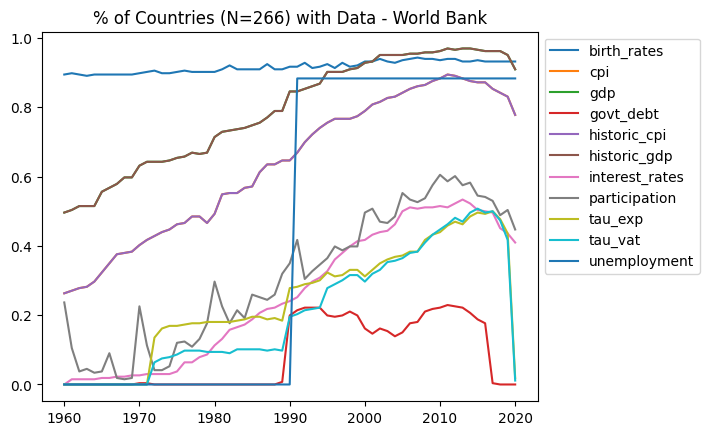

In [5]:
wb_missing_time(wb_dict)

### Countries with Complete IR Data after 1990

1. New Zealand (NZL)
2. Austria (AUT)
3. Belgium (BEL)
4. United States (USA)
5. Netherlands (NLD)
6. Sweden (SWE)
7. Findland (FIN)
8. Australia (AUS)
9. Canada (CAN)
10. Ireland (IRL)
11. South Africa (ZAF)
12. United Kingdom (GBR)
13. Spain (ESP)
14. France (FRA)
15. Germany (DEU)
16. Denmark (DNK)
17. Norway (NOR)

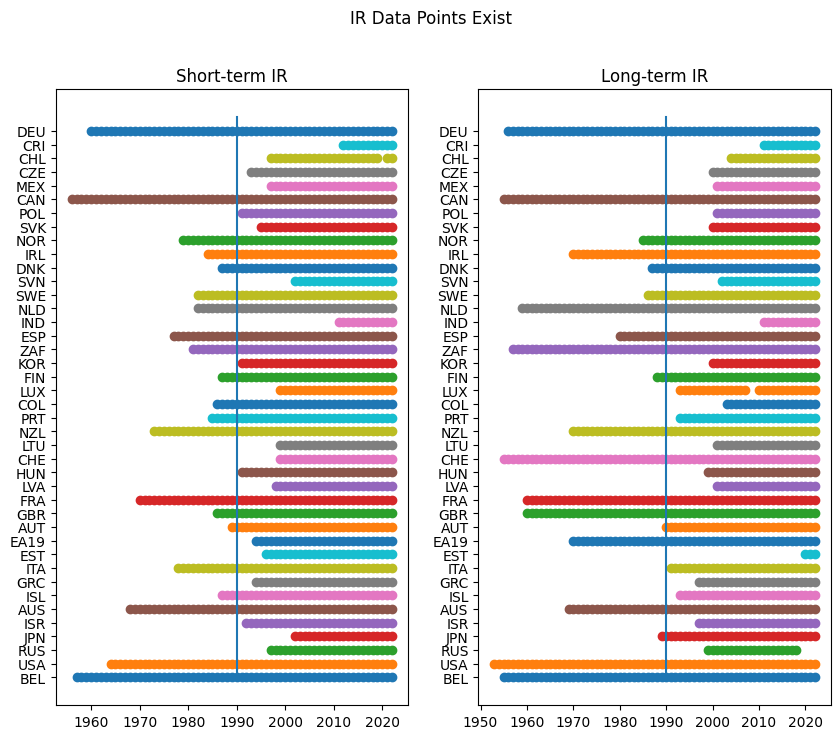

In [6]:
wb_missing_ir(wb_dict)

## Most Data Rich Countries in World Bank Data since 1991

1. Austria (AUS)
4. South Africa (ZAF) - worst is participation (missing 2)
2. United States (USA) - worst is tau_vat (missing 7)
3. United Kingdom (GBR) - worst is interest_rates (missing 6)
5. Netherlands (NLD) - worst is interest_rates (missing 15)

In [7]:
countries = list(np.unique(wb_dict['short_term_ir']['LOCATION']))
countries.remove('EA19')

In [55]:
ir_data_rich = ['NZL','AUT','BEL','USA','NLD','SWE','FIN','AUS','CAN','IRL','ZAF','GBR','ESP','FRA','DEU','DNK','NOR']
years_str = [str(i) for i in range(1991, 2021)]
rows = []

for country in countries:
    row = {}
    row['country'] = country
    row['total'] = 0
    for key, df in wb_dict.items():
        # gdp and cpi are equivalent and govt_debt unimportant according to documentation
        if not key in ['historic_gdp', 'historic_cpi', 'long_term_ir', 'short_term_ir', 'govt_debt']: 
            row[key] =  np.sum(df[df.index == country][years_str].isna(), axis=1).values[0]
            row['total'] += np.sum(df[df.index == country][years_str].isna(), axis=1).values[0]
    rows.append(row)

pd.DataFrame(rows).sort_values('total')

,country,total,birth_rates,cpi,gdp,interest_rates,participation,tau_exp,tau_vat,unemployment
24,ITA,2,0,0,0,0,0,1,1,0
0,AUS,3,0,0,0,1,0,1,1,0
8,CRI,4,0,0,0,0,0,1,3,0
41,ZAF,4,0,0,0,0,2,1,1,0
26,KOR,7,0,0,0,5,0,1,1,0
40,USA,7,0,0,0,0,0,0,7,0
18,HUN,7,0,0,0,1,0,1,5,0
16,GBR,9,0,0,0,6,1,1,1,0
9,CZE,10,0,1,0,2,1,3,3,0
22,ISL,11,0,0,0,5,0,1,5,0


In [79]:
pd.set_option('display.max_rows', 300, 'display.max_columns', 100)

temp = wb_dict['interest_rates'][[str(y) for y in range(2000,2022)]]

data = {}

temp = temp.loc[['AUT','BEL','BGR','HRV','CYP','CZE','DNK','EST','FIN','FRA','DEU','GRC','HUN','IRL','ITA','LVA','LTU','LUX','MLT','NLD','POL','PRT','ROU','SVK','SVN','ESP','SWE','ZAF','USA','GBR','BRA']]


data = {}
for i, row in temp.iterrows():
    data[i] = [i for i, v in enumerate(row) if not (v > 0 or v < 0)]

data

{'AUT': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 'BEL': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 'BGR': [21],
 'HRV': [15, 16, 17, 18, 19, 20, 21],
 'CYP': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 'CZE': [21],
 'DNK': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 'EST': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 'FIN': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 'FRA': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 'DEU': [0,
  1,
  2,
  

## WIOD Data

In [9]:
pd.read_csv('sample_data/WIOT2012_Nov16_ROW.csv')

/var/folders/c5/1ykwfx953hdd7lps3nkt7myr0000gn/T/ipykernel_12606/1980148449.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

,Intercountry Input-Output Table,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 2679,Unnamed: 2680,Unnamed: 2681,Unnamed: 2682,Unnamed: 2683,Unnamed: 2684,Unnamed: 2685,Unnamed: 2686,Unnamed: 2687,Unnamed: 2688
0,"43 countries, in current prices",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,(industry-by-industry),NaN,NaN,NaN,A01,A02,A03,B,C10-C12,C13-C15,...,CONS_np,CONS_g,GFCF,INVEN,CONS_h,CONS_np,CONS_g,GFCF,INVEN,GO
2,(millions of US$),NaN,NaN,NaN,"Crop and animal production, hunting and relate...",Forestry and logging,Fishing and aquaculture,Mining and quarrying,"Manufacture of food products, beverages and to...","Manufacture of textiles, wearing apparel and l...",...,Final consumption expenditure by non-profit or...,Final consumption expenditure by government,Gross fixed capital formation,Changes in inventories and valuables,Final consumption expenditure by households,Final consumption expenditure by non-profit or...,Final consumption expenditure by government,Gross fixed capital formation,Changes in inventories and valuables,Total output
3,NaN,NaN,NaN,NaN,AUS,AUS,AUS,AUS,AUS,AUS,...,USA,USA,USA,USA,ROW,ROW,ROW,ROW,ROW,TOT
4,NaN,NaN,NaN,NaN,c1,c2,c3,c4,c5,c6,...,c58,c59,c60,c61,c57,c58,c59,c60,c61,c62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,PURR,Direct purchases abroad by residents,TOT,r68,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2473,PURNR,Purchases on the domestic territory by non-res...,TOT,r69,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2474,VA,Value added at basic prices,TOT,r70,"33,166","1,354","1,680","121,489","26,293","2,855",...,0,0,0,0,0,0,0,0,0,0
2475,IntTTM,International Transport Margins,TOT,r71,252,24,25,"1,090",249,86,...,0,0,"28,811","1,025",0,0,0,0,0,0


## OECD Data

## WHO Data

In [10]:
accounts_df  = pd.read_csv('sample_data/Socio_Economic_Accounts.csv')

In [11]:
f = h5py.File('./sample_data/oecd_econ_data.h5', 'r')
print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]
a_group_key

oecd_dict = {}
for i in f.keys():
    oecd_dict[i] = pd.read_hdf('./sample_data/oecd_econ_data.h5', key=i)



Keys: <KeysViewHDF5 ['business_birth_rates', 'business_death_rates', 'business_demography', 'employment_by_industry', 'tau_firm', 'tau_inc', 'tau_sif', 'tau_siw', 'total_benefits', 'unemployment_benefits']>
